In [1]:
import torch
import torch.nn as nn

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [4]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.reshape(-1)/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


/home/arn/Documents/PML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x,_) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            if epoch % 3000 == 0:
                per_epoch_callback(ema_model.module if ema else model)



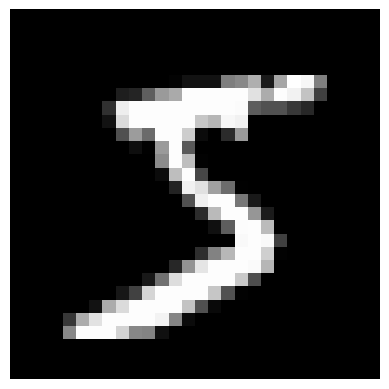

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
Training:   0%|          | 1/100000 [00:01<34:19:59,  1.24s/it, epoch=1/100000, loss=⠀      6.6827, lr=1.00E-03]

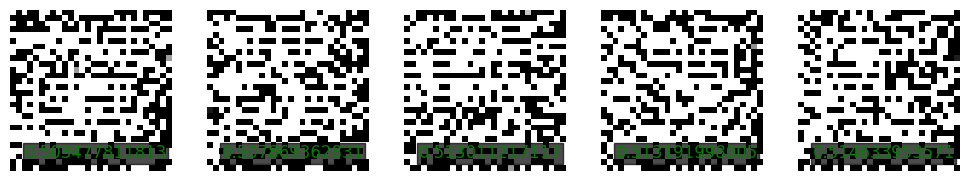

Training:   3%|▎         | 3000/100000 [00:34<15:26, 104.67it/s, epoch=3001/100000, loss=⠀      0.0284, lr=7.41E-04]

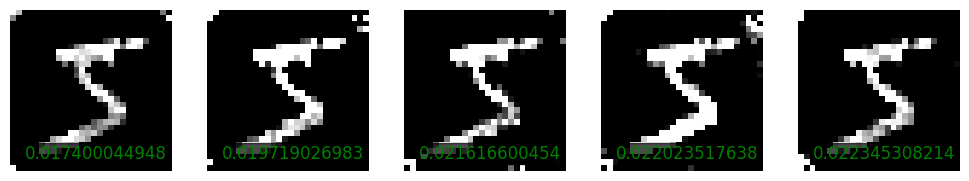

Training:   6%|▌         | 6000/100000 [01:05<15:15, 102.71it/s, epoch=6001/100000, loss=⠀      0.0175, lr=5.49E-04] 

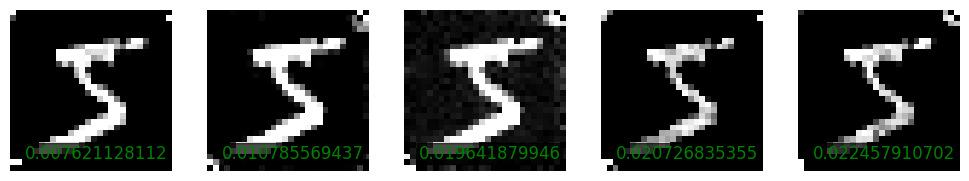

Training:   9%|▉         | 9000/100000 [01:37<15:10, 100.00it/s, epoch=9001/100000, loss=⠀      0.0167, lr=4.07E-04] 

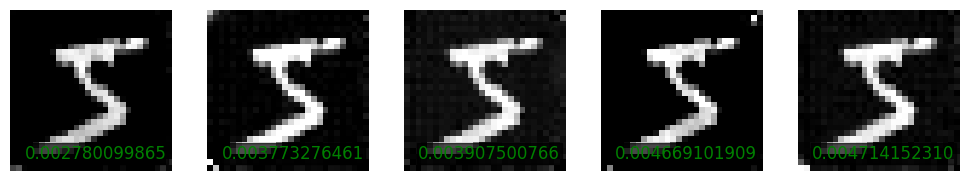

Training:  12%|█▏        | 12000/100000 [02:11<15:31, 94.52it/s, epoch=12001/100000, loss=⠀      0.0075, lr=3.01E-04] 

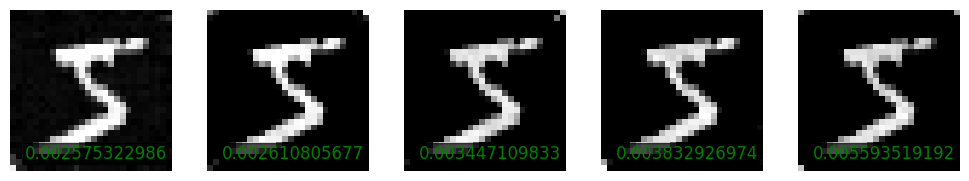

Training:  15%|█▌        | 15000/100000 [02:46<14:21, 98.69it/s, epoch=15001/100000, loss=⠀      0.0132, lr=2.23E-04]  

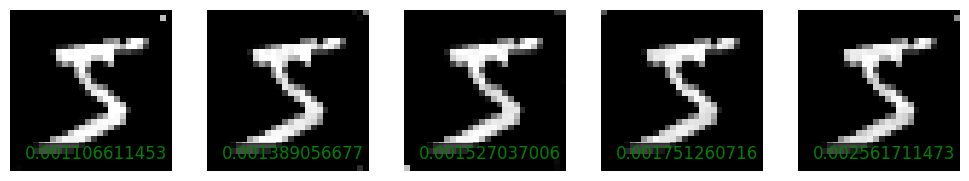

Training:  18%|█▊        | 18000/100000 [03:20<15:39, 87.26it/s, epoch=18001/100000, loss=⠀      0.0092, lr=1.65E-04]  

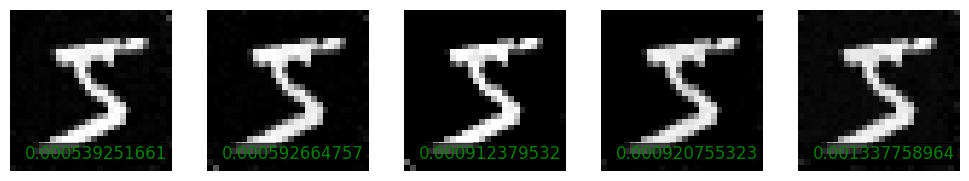

Training:  21%|██        | 21000/100000 [03:54<14:12, 92.71it/s, epoch=21001/100000, loss=⠀      0.0090, lr=1.22E-04]  

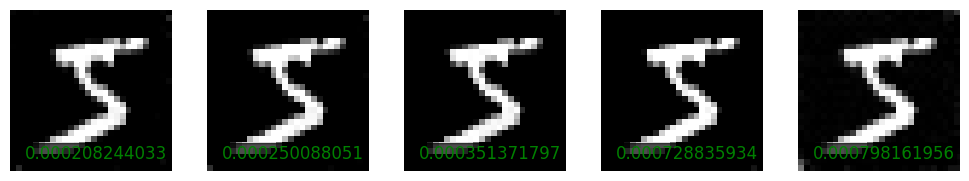

Training:  24%|██▍       | 24000/100000 [04:27<12:23, 102.20it/s, epoch=24001/100000, loss=⠀      0.0070, lr=9.07E-05] 

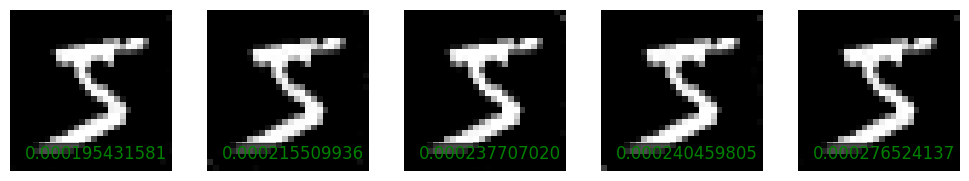

Training:  27%|██▋       | 27000/100000 [05:00<12:33, 96.91it/s, epoch=27001/100000, loss=⠀      0.0092, lr=6.72E-05]  

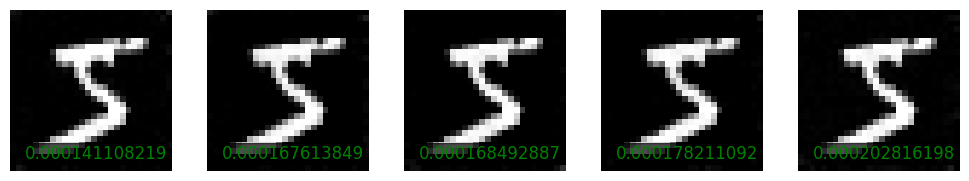

Training:  30%|███       | 30001/100000 [05:33<12:07, 96.28it/s, epoch=30001/100000, loss=⠀      0.0062, lr=4.98E-05]  

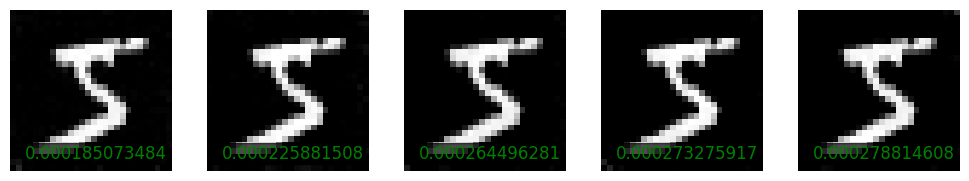

Training:  33%|███▎      | 33000/100000 [06:04<10:25, 107.17it/s, epoch=33001/100000, loss=⠀      0.0098, lr=3.69E-05] 

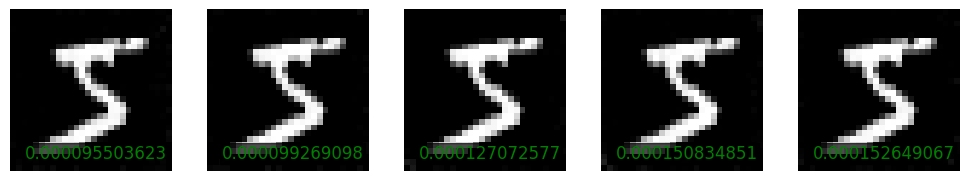

Training:  36%|███▌      | 36000/100000 [06:35<10:05, 105.73it/s, epoch=36001/100000, loss=⠀      0.0047, lr=2.73E-05] 

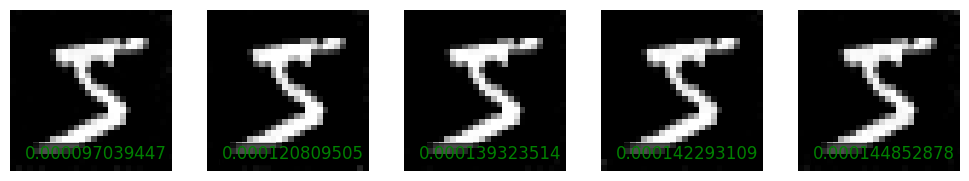

Training:  39%|███▉      | 39000/100000 [07:06<11:08, 91.25it/s, epoch=39001/100000, loss=⠀      0.0085, lr=2.02E-05]  

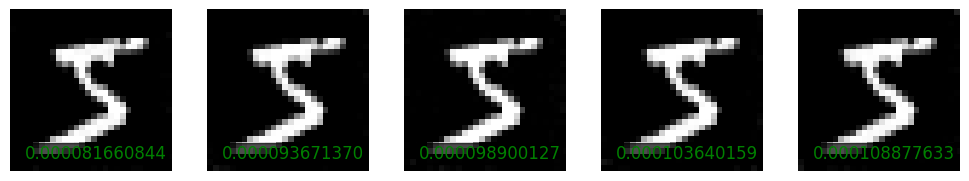

Training:  42%|████▏     | 42000/100000 [07:37<08:50, 109.29it/s, epoch=42001/100000, loss=⠀      0.0049, lr=1.50E-05] 

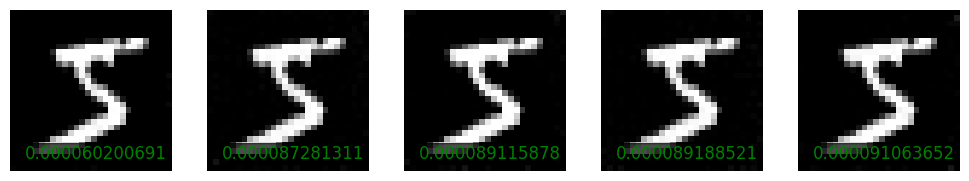

Training:  45%|████▌     | 45000/100000 [08:07<09:00, 101.75it/s, epoch=45001/100000, loss=⠀      0.0040, lr=1.11E-05] 

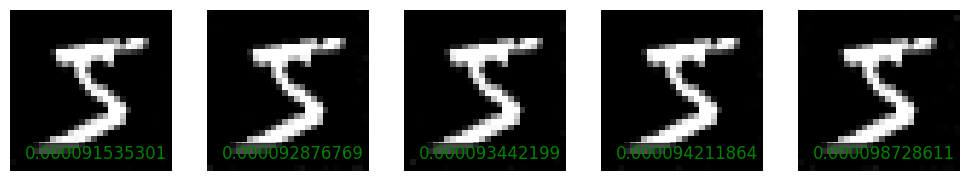

Training:  48%|████▊     | 48000/100000 [08:38<08:15, 104.86it/s, epoch=48001/100000, loss=⠀      0.0055, lr=8.23E-06] 

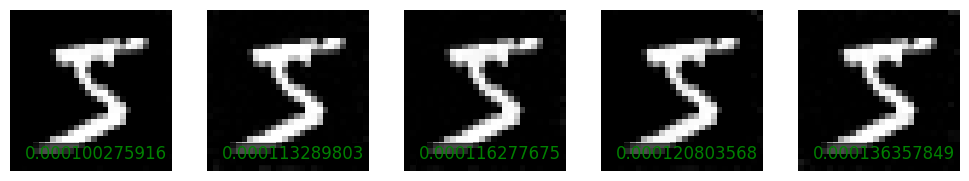

Training:  51%|█████     | 51000/100000 [09:09<07:39, 106.69it/s, epoch=51001/100000, loss=⠀      0.0050, lr=6.09E-06]

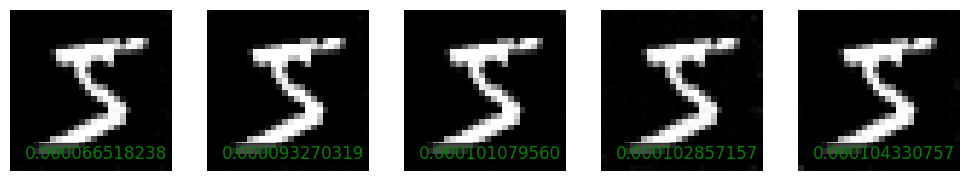

Training:  54%|█████▍    | 54000/100000 [09:39<07:14, 105.94it/s, epoch=54001/100000, loss=⠀      0.0084, lr=4.51E-06]

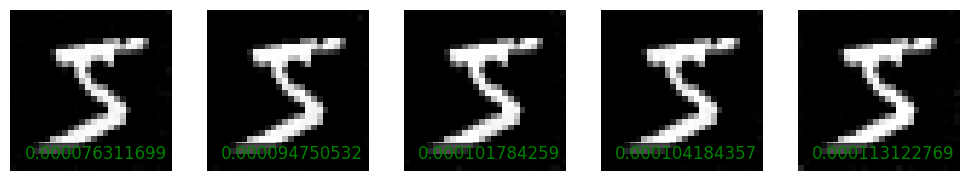

Training:  57%|█████▋    | 57000/100000 [10:10<06:50, 104.86it/s, epoch=57001/100000, loss=⠀      0.0055, lr=3.34E-06]

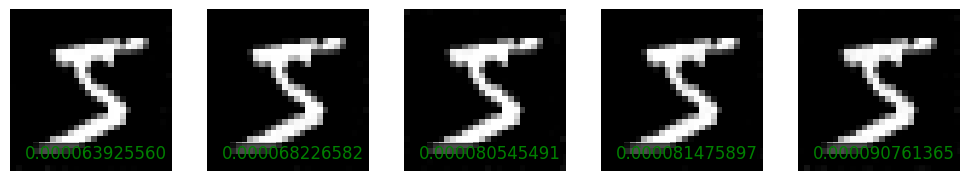

Training:  60%|██████    | 60000/100000 [10:41<06:03, 109.98it/s, epoch=60001/100000, loss=⠀      0.0069, lr=2.48E-06]

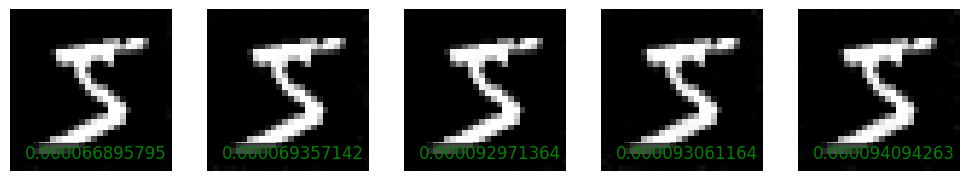

Training:  63%|██████▎   | 63000/100000 [11:12<05:44, 107.32it/s, epoch=63001/100000, loss=⠀      0.0061, lr=1.84E-06]

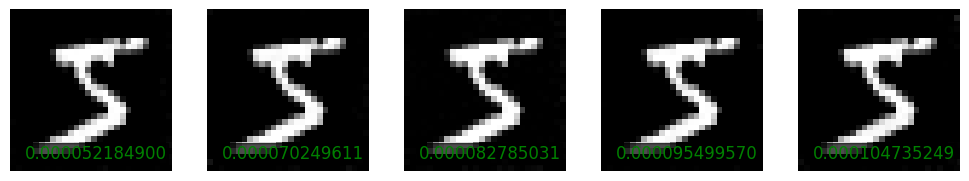

Training:  66%|██████▌   | 66000/100000 [11:43<05:20, 105.96it/s, epoch=66001/100000, loss=⠀      0.0065, lr=1.36E-06]

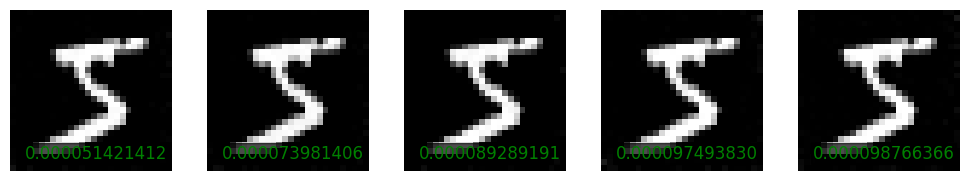

Training:  69%|██████▉   | 69000/100000 [12:13<05:03, 102.21it/s, epoch=69001/100000, loss=⠀      0.0053, lr=1.01E-06]

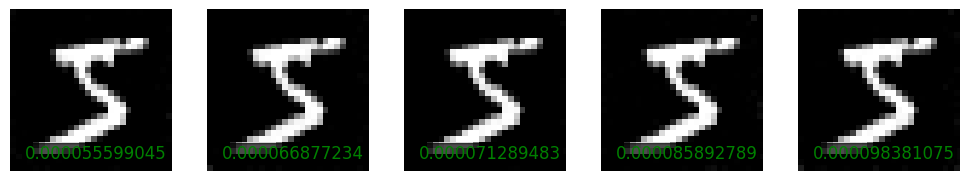

Training:  72%|███████▏  | 72000/100000 [12:44<04:24, 105.85it/s, epoch=72001/100000, loss=⠀      0.0107, lr=7.46E-07]

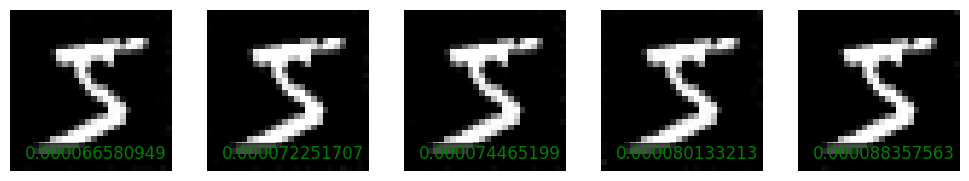

Training:  75%|███████▌  | 75000/100000 [13:13<03:17, 126.37it/s, epoch=75001/100000, loss=⠀      0.0048, lr=5.53E-07]

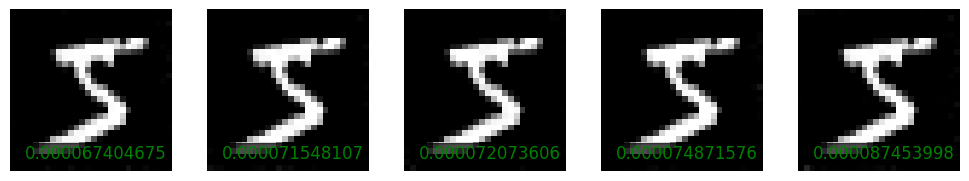

Training:  78%|███████▊  | 78001/100000 [13:39<02:50, 129.09it/s, epoch=78001/100000, loss=⠀      0.0043, lr=4.10E-07]

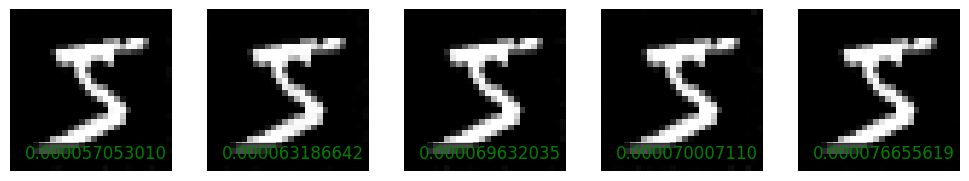

Training:  81%|████████  | 81000/100000 [14:04<02:33, 123.93it/s, epoch=81001/100000, loss=⠀      0.0058, lr=3.03E-07]

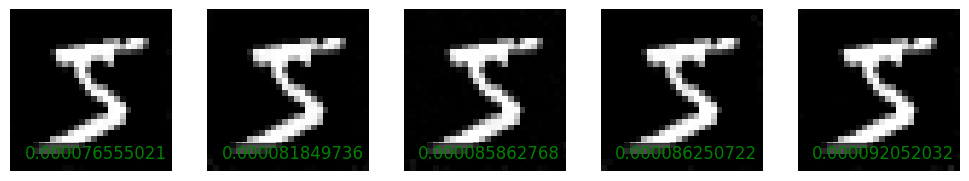

Training:  84%|████████▍ | 84000/100000 [14:30<02:06, 126.67it/s, epoch=84001/100000, loss=⠀      0.0036, lr=2.25E-07]

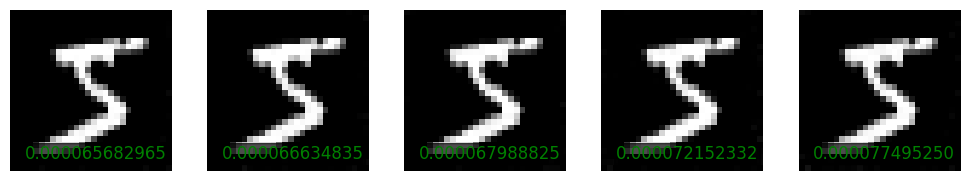

Training:  87%|████████▋ | 87000/100000 [14:57<01:41, 128.46it/s, epoch=87001/100000, loss=⠀      0.0055, lr=1.66E-07]

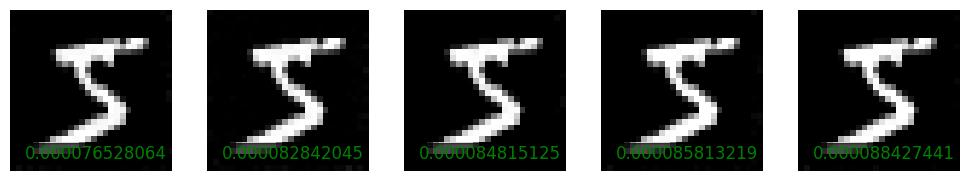

Training:  90%|█████████ | 90000/100000 [15:23<01:23, 120.06it/s, epoch=90001/100000, loss=⠀      0.0044, lr=1.23E-07]

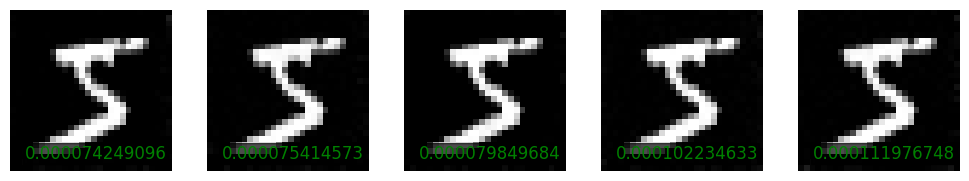

Training:  93%|█████████▎| 93000/100000 [15:48<00:55, 126.24it/s, epoch=93001/100000, loss=⠀      0.0087, lr=9.14E-08]

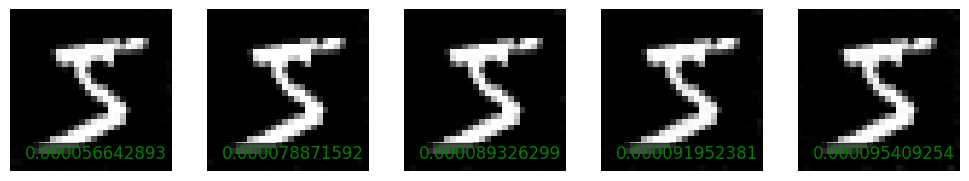

Training:  96%|█████████▌| 96001/100000 [16:14<00:30, 131.63it/s, epoch=96001/100000, loss=⠀      0.0056, lr=6.77E-08]

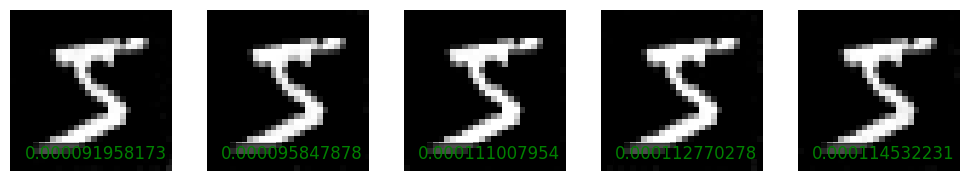

Training:  99%|█████████▉| 99000/100000 [16:40<00:07, 125.61it/s, epoch=99001/100000, loss=⠀      0.0042, lr=5.01E-08]

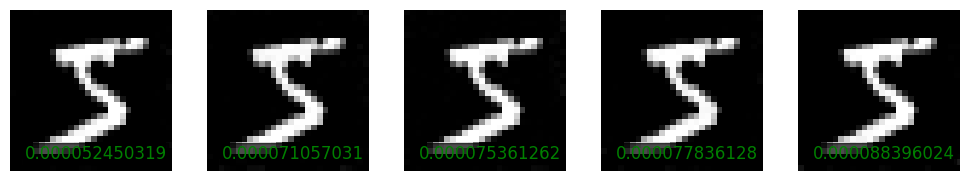

Training: 100%|██████████| 100000/100000 [16:50<00:00, 98.94it/s, epoch=100000/100000, loss=⠀      0.0034, lr=4.54E-08]


[0.5034778118133545, 0.017400044947862625, 0.007621128112077713, 0.0027800998650491238, 0.002575322985649109, 0.0011066114529967308, 0.0005392516613937914, 0.0002082440332742408, 0.00019543158123269677, 0.00014110821939539164, 0.00018507348431739956, 9.550362301524729e-05, 9.703944670036435e-05, 8.166084444383159e-05, 6.020069122314453e-05, 9.153530118055642e-05, 0.00010027591633843258, 6.651823787251487e-05, 7.631169864907861e-05, 6.392555951606482e-05, 6.689579458907247e-05, 5.2184899686835706e-05, 5.14214116265066e-05, 5.559904457186349e-05, 6.658094935119152e-05, 6.740467506460845e-05, 5.705301009584218e-05, 7.655502122361213e-05, 6.568296521436423e-05, 7.652806380065158e-05, 7.424909563269466e-05, 5.664289346896112e-05, 9.195817256113514e-05, 5.2450319344643503e-05]


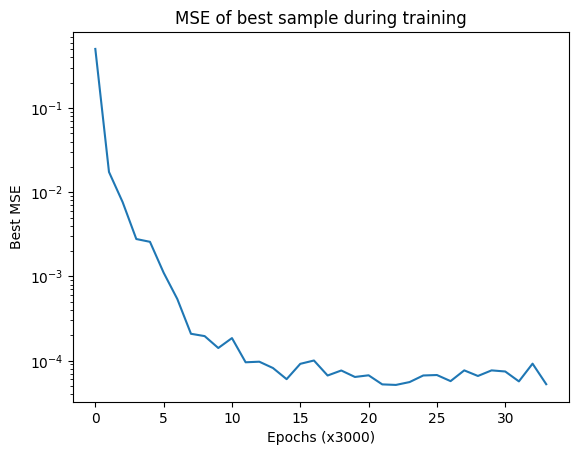

In [6]:
# Only train on a single MNIST image for memorization

# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100000


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])


# Only have a single image in the dataset for memorization
dataset = datasets.MNIST('./mnist_data', download=True, train=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, [0]),
                                               batch_size=1,
                                                shuffle=True)

# display the image we are going to memorize
ground_image, _ = dataset[0]
plt.gca().set_axis_off()
plt.imshow(transforms.functional.to_pil_image((ground_image.reshape(28,28)+1)/2), cmap="gray")
plt.show()


# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ground_image = ((ground_image.flatten()+1)/2).to(device)

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

mse_list = []

def reporter(model):
    """
    Callback function used for plotting images during training.
    Also checks how well the model has memorized the image.
    """
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 100
        samples = model.sample((nsamples,28*28))
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Compute MSE with ground truth image
        # Find MSE for all samples
        mse = nn.MSELoss(reduction='none')(samples, ground_image.expand_as(samples)).mean(dim=1)
        
        best_mse = torch.min(mse).item()
        mse_list.append(best_mse)

        # Plot top 5 samples with MSE values overlaid on the images
        topk = torch.topk(mse, 5, largest=False)
        best_indices = topk.indices
        best_samples = samples[best_indices].reshape(-1, 1, 28, 28)

        fig, axes = plt.subplots(1, 5, figsize=(10, 2))
        for i, ax in enumerate(axes):
            img = transforms.functional.to_pil_image(best_samples[i])
            ax.imshow(img, cmap="gray")
            ax.axis('off')
            ax.text(2, 26, f"{topk.values[i].item():.12f}", color='green',
                fontsize=12, ha='left', va='bottom',
                bbox=dict(facecolor='black', alpha=0.7, pad=1))
        plt.tight_layout()
        plt.show()

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

print(mse_list)
# Plot MSE over training
plt.plot(mse_list)
plt.yscale("log")
plt.xlabel("Epochs (x3000)")
plt.ylabel("Best MSE")
plt.title("MSE of best sample during training")
plt.show()